In [2]:
import pydicom
import numpy as np
from skimage.transform import resize,rescale
from skimage import img_as_ubyte
import matplotlib.pyplot as plt
import os
import pandas as pd

# hough ellipse transform
from skimage import data, color, img_as_ubyte
from skimage.feature import canny
from skimage.transform import hough_ellipse, resize
from skimage.draw import ellipse_perimeter
from skimage.color import gray2rgb
import skimage.io as io

# inmediate data process
from utils import normalize, get_rois, plot_axis, read_data
from utils import read_rois_and_axis_data

# segmentation
from segmentation_model import unet_model

# detection
from detection_model import Net, num_classes
from detection_machine import Detection

# registration
from registration_machine import Semi_auto_registration

# hyperparameters
from utils import input_size, img_height, img_width

D:\anaconda\envs\tf1\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\anaconda\envs\tf1\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\anaconda\envs\tf1\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\anaconda\envs\tf1\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or 

ImportError: cannot import name 'Semi_auto_registration' from 'registration_machine' (D:\我的代码\jupyter notebook\Programs\MRI mapping\registration_machine.py)

## Méthode 1 Match par position correspodante
Nous trouvons que les positions ne sont pas correspondantes

In [24]:
def axis_size_match(axis_ens, src_size, tgt_size):
    new_axis_ens = axis_ens.copy()
    
    x_scale = tgt_size[1]*1.0/src_size[1]
    y_scale = tgt_size[0]*1.0/src_size[0]
    
    new_axis_ens[:,0] = np.round(new_axis_ens[:,0]*x_scale)              # x
    new_axis_ens[:,1] = np.round(new_axis_ens[:,1]*y_scale)              # y
    new_axis_ens[:,2] = np.round(new_axis_ens[:,2]*x_scale)              # w
    new_axis_ens[:,3] = np.round(new_axis_ens[:,3]*y_scale)              # h
    
    return new_axis_ens

In [25]:
# 之前用的是T1 SAG文件，找到其对应的T1，T2和T2*文件
## T1 SAG
f0 = r'D:\课件\ECN第二年DATASIM\Projet\projet mapping segmentation\IRM_brut\Brebis 7 (40560)\J-7\IRM\10248_Brebis_40560\Neuro_Rachis - 1\T1_TSE_SAG_4\IM-0002-0004.dcm'
ds0 = pydicom.dcmread(f0)      # dcm format 
im0 = ds0.pixel_array          # array 

## T1
f1 = r'D:\课件\ECN第二年DATASIM\Projet\projet mapping segmentation\IRM_brut\Brebis 7 (40560)\J-7\IRM\10248_Brebis_40560\Neuro_Rachis - 1\T1_Images_10\IM-0008-0013.dcm'
ds1 = pydicom.dcmread(f1)     
im1 = ds1.pixel_array          

im1_mean, im1_std = im1.mean(), im1.std() 
im1 = (im1-im1.mean())/im1.std()   

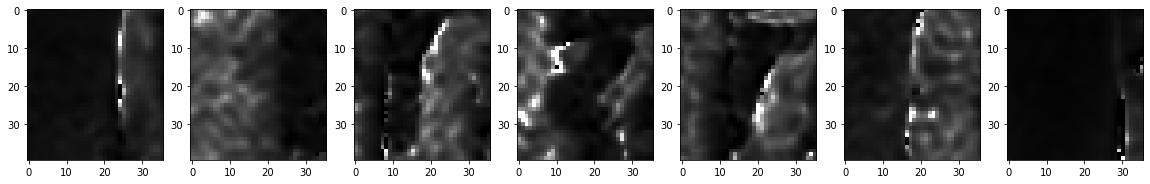

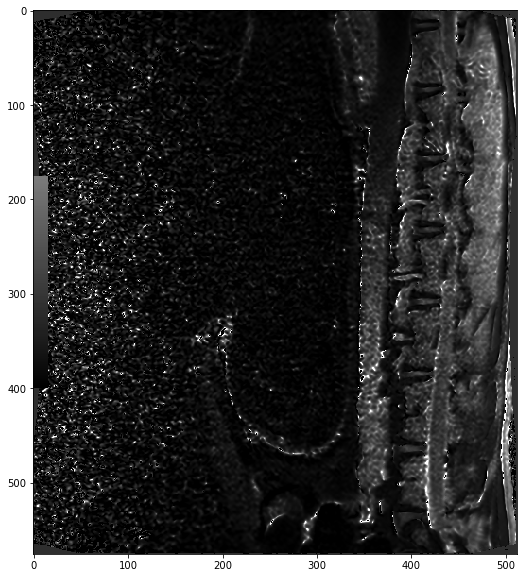

In [26]:
# axis match
rois_axis_ens_matched = axis_size_match(rois_axis_ens[0], im0.shape, im1.shape)
im1_rois = get_rois(im1, rois_axis_ens_matched, if_modify_size = False)

N = len(rois_axis_ens[0])
plt.figure(figsize=(20,5))
for i in range(N):
    plt.subplot(1,N,i+1)
    plt.imshow(im1_rois[i].squeeze(), cmap = 'gray')
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(im1, cmap = 'gray')
plt.show()

In [27]:
# resize + normalize(scale 0~1), resize的时候要暂时将channels维度放在最后一维上
tgt_size = ims_T1sag.shape[1:]
ims_T1sag = normalize(ims_T1sag)
ims_T2sag = normalize(ims_T2sag)
ims_T1 = normalize(ims_size_match(ims_T1, tgt_size))
ims_T2 = normalize(ims_size_match(ims_T2, tgt_size))
ims_T2star = normalize(ims_size_match(ims_T2star, tgt_size))

print(ims_T1sag.mean(), ims_T1sag.dtype)
print(ims_T2sag.mean(), ims_T2sag.dtype)
print(ims_T1.mean(), ims_T1.dtype)
print(ims_T2.mean(), ims_T2.dtype)
print(ims_T2star.mean(), ims_T2star.dtype)

0.0883776521645326 float64
0.08404625194409306 float64
0.13670565448687183 float64
0.03844875646287534 float64
0.012676802778167472 float64


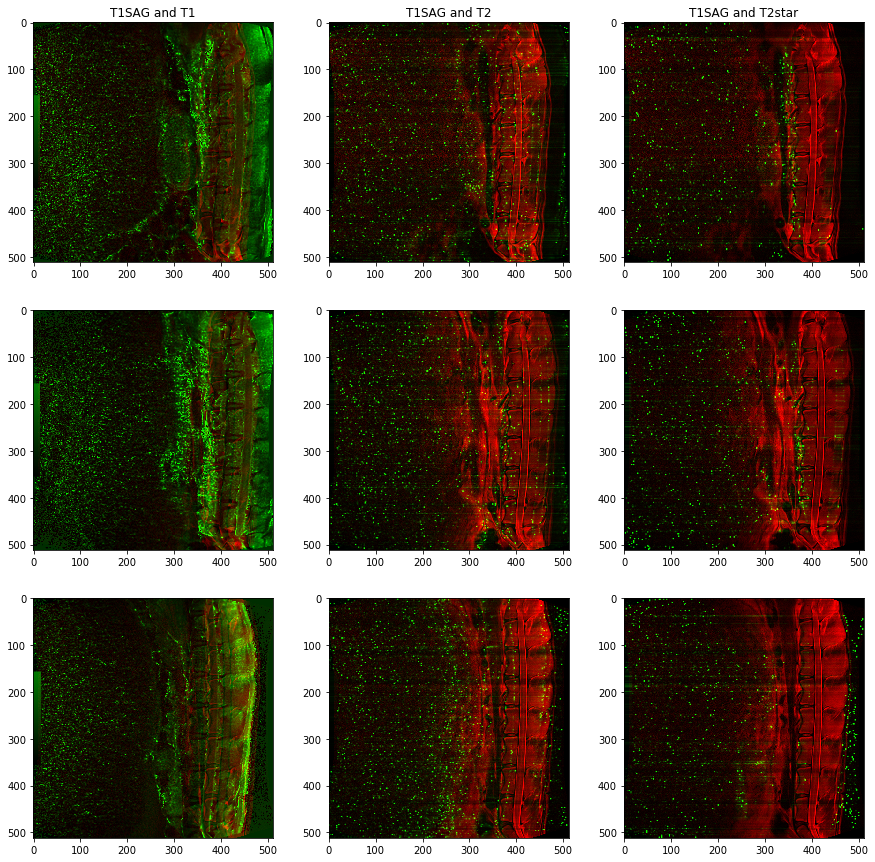

In [28]:
# show fusion images
N = 3
plt.figure(figsize=(5*3,5*N))
for i in range(N):
    im_T1sag = ims_T1sag[i]
    im_T2sag = ims_T2sag[i]
    im_T1 = ims_T1[i]
    im_T2 = ims_T2[i]
    im_T2star = ims_T2star[i]
    
    blend1 = np.zeros((tgt_size[0], tgt_size[1], 3))
    blend1[:,:,0] = im_T1sag       # red channe;
    blend1[:,:,1] = im_T1          # green channe;
    
    blend2 = np.zeros((tgt_size[0], tgt_size[1], 3))
    blend2[:,:,0] = normalize(im_T2sag)     
    blend2[:,:,1] = normalize(im_T2)          
    
    blend3 = np.zeros((tgt_size[0], tgt_size[1], 3))
    blend3[:,:,0] = normalize(im_T2sag)       
    blend3[:,:,1] = normalize(im_T2star)     
    
    plt.subplot(N,3,3*i+1)
    plt.imshow(blend1)
    if i == 0:
        plt.title('T1SAG and T1')
    plt.subplot(N,3,3*i+2)
    plt.imshow(blend2)
    if i == 0:
        plt.title('T1SAG and T2')
    plt.subplot(N,3,3*i+3)
    plt.imshow(blend3)
    if i == 0:
        plt.title('T1SAG and T2star')
    
plt.show()

In [124]:
# save fusion images 
dir_fusion = './fusion'
if not os.path.exists(dir_fusion):
    os.makedirs(dir_fusion)

N = 1
for i in range(N):
    im_T1sag = ims_T1sag[i]
    im_T1 = ims_T1[i]
    im_T2 = ims_T2[i]
    im_T2star = ims_T2star[i]

    blend1 = np.zeros((tgt_size[0], tgt_size[1], 3))
    blend1[:,:,0] = im_T1sag       # red channe;
    blend1[:,:,1] = im_T1          # green channe;
    
    blend2 = np.zeros((tgt_size[0], tgt_size[1], 3))
    blend2[:,:,0] = normalize(im_T1sag)       # red channe;
    blend2[:,:,1] = normalize(im_T2)          # green channe;
    
    blend3 = np.zeros((tgt_size[0], tgt_size[1], 3))
    blend3[:,:,0] = im_T1sag       # red channe;
    blend3[:,:,1] = im_T2star      # green channe;
    
    io.imsave(os.path.join(dir_fusion, str(i+1)+'_T1sag&T1'+'.tiff'), blend1.astype(np.float32))
    io.imsave(os.path.join(dir_fusion, str(i+1)+'_T1sag&T2'+'.tiff'), blend2.astype(np.float32))   
    io.imsave(os.path.join(dir_fusion, str(i+1)+'_T1sag&T2star'+'.tiff'), blend3.astype(np.float32))   

## Méthode 2 Recherche des Ellipses
Nous trouvons qu'il y n'a pas de packages qui peuvent exporter les ellipses en .roi  

In [29]:
def axis_from_xyabo_to_xywh(axis_ens):
    axis_out = []
    for (x,y,a,b,orientation) in axis_ens:
        # orientation 是从0到pi的,0的时候是竖直的,pi/2的时候是水平的
        if orientation%np.pi > 3/4*np.pi or orientation%np.pi < 1/4*np.pi:
            x1 = x - round(a*np.sin(orientation))
            y1 = y - round(b*np.abs(np.cos(orientation)))
            w = round(2*a*np.sin(orientation))
            h = round(2*b*np.abs(np.cos(orientation)))
        else:
            x1 = x - round(a*np.abs(np.cos(orientation)))
            y1 = y - round(b*np.sin(orientation))
            w = round(2*b*np.sin(orientation))
            h = round(2*a*np.abs(np.cos(orientation)))
        axis_out.append([x1, y1, w, h])
    return np.array(axis_out)

In [57]:
dir_rois = r'.\intermediate_results\1'
rois_ens, _ = read_rois_and_axis_data(dir_rois)
rois_ens = rois_ens[0]

Y1_pred = model1.predict(rois).squeeze()
Y2_pred = model2.predict(rois).squeeze()

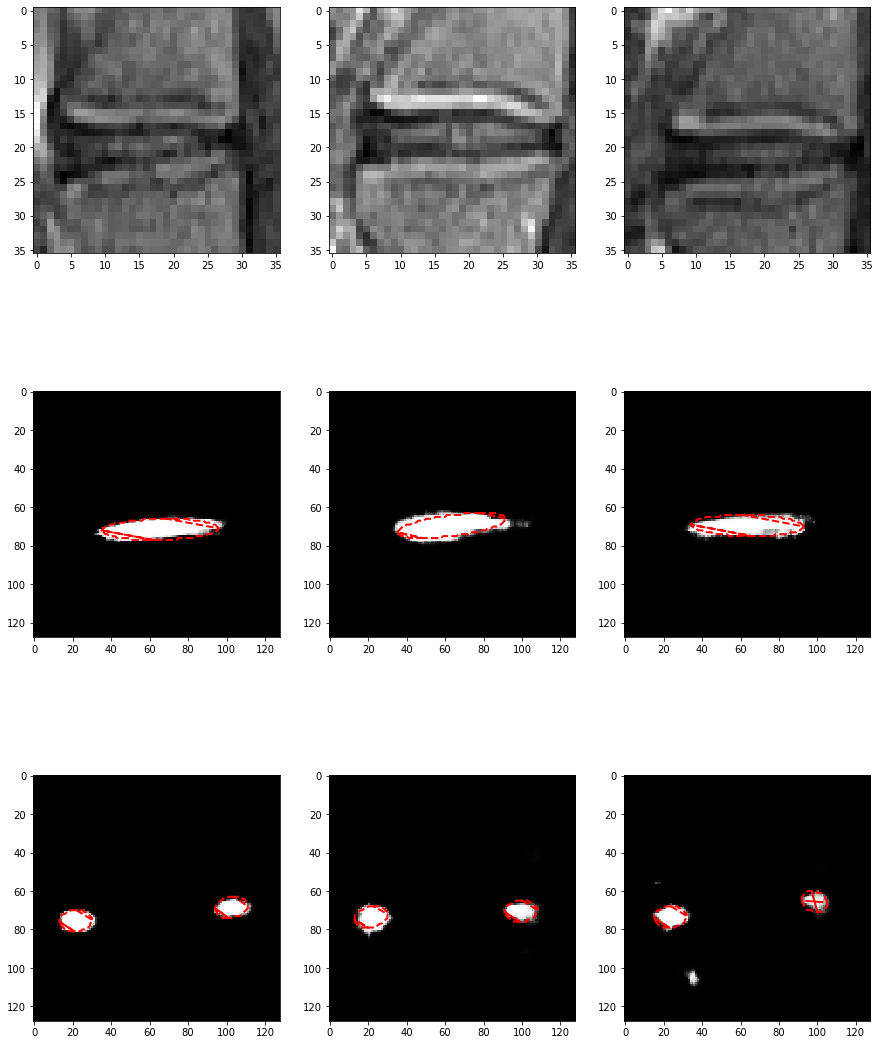

[[66, 72, 5, 30, 3.124645123783388], [64, 70, 5, 28, 3.0172376590430314], [64, 70, 29, 5, 1.588338386852299]]
[[66. 42.  0. 60.]
 [63. 42.  1. 56.]
 [63. 65. 10.  1.]]


In [58]:
axis_ellipse_cen = []
axis_ellipse_left = []
axis_ellipse_right = []
plt.figure(figsize = (N*5,4*5))
for i in range(N):
    roi = rois_ens[i].squeeze()
    y1_pred = Y1_pred[i]
    y2_pred = Y2_pred[i]
    
    #1/ original rois prediction
    plt.subplot(3,N,i+1)
    plt.imshow(roi,cmap='gray')
    
    #2/ center
    # Perform a Hough Transform
    edges = canny(y1_pred, sigma=5)
    result = hough_ellipse(edges, accuracy=5, threshold=1)
    result.sort(order='accumulator')
    # Estimated parameters for the ellipse
    best = list(result[-1])
    yc, xc, a, b = [int(round(x)) for x in best[1:5]]
    orientation = best[5]
    # Draw the ellipse on the original image
    cy, cx = ellipse_perimeter(yc, xc, a, b, orientation)
    init = np.array([cx, cy]).T   
    
    plt.subplot(3,N,N+i+1)
    plt.imshow(y1_pred,cmap='gray')
    plt.plot(init[:, 0], init[:, 1], '--r', lw=2)
    
    #3/ both sides
    y2_pred = Y2_pred[i]
    y2_pred_left = y2_pred.copy()
    y2_pred_left[:,y2_pred_left.shape[1]//2:] = 0
    y2_pred_right = y2_pred.copy()
    y2_pred_right[:,:y2_pred_right.shape[1]//2] = 0
    
    ## 3.1/ left
    # Perform a Hough Transform
    edges = canny(y2_pred_left, sigma=5)
    result = hough_ellipse(edges, accuracy=5, threshold=1)
    result.sort(order='accumulator')
    # Estimated parameters for the ellipse
    best1 = list(result[-1])
    yc1, xc1, a1, b1 = [int(round(x)) for x in best1[1:5]]
    orientation1 = best1[5]
    # Draw the ellipse on the original image
    cy1, cx1 = ellipse_perimeter(yc1, xc1, a1, b1, orientation1)
    init1 = np.array([cx1, cy1]).T 
    
    ## 3.2/ right
    edges = canny(y2_pred_right, sigma=5)
    result = hough_ellipse(edges, accuracy=5, threshold=1)
    result.sort(order='accumulator')
    # Estimated parameters for the ellipse
    best2 = list(result[-1])
    yc2, xc2, a2, b2 = [int(round(x)) for x in best2[1:5]]
    orientation2 = best2[5]
    # Draw the ellipse on the original image
    cy2, cx2 = ellipse_perimeter(yc2, xc2, a2, b2, orientation2)
    init2 = np.array([cx2, cy2]).T 
    
    plt.subplot(3,N,2*N+i+1)
    plt.imshow(y2_pred,cmap='gray')
    plt.plot(init1[:, 0], init1[:, 1], '--r', lw=2)
    plt.plot(init2[:, 0], init2[:, 1], '--r', lw=2)
    
    # save to variables
    axis_ellipse_cen.append([xc, yc, a, b, orientation])
    axis_ellipse_left.append([xc1, yc1, a1, b1, orientation1])
    axis_ellipse_right.append([xc2, yc2, a2, b2, orientation2])

plt.show()

print(axis_ellipse_cen)
axis_ellipse_cen = axis_from_xyabo_to_xywh(axis_ellipse_cen)
axis_ellipse_left = axis_from_xyabo_to_xywh(axis_ellipse_left)
axis_ellipse_right = axis_from_xyabo_to_xywh(axis_ellipse_right)
print(axis_ellipse_cen)

## Méthode 4 Semi-Automatique (positions choisies manuellement)
Read the man-made location of ROIs in T1, T2 and T2*.

In [ ]:
# registration
from registration machine import Semi_auto_registration

# recalage semi-automatique et recherche de valeur
root_path = 'D:\课件\ECN第二年DATASIM\Projet\projet mapping segmentation\IRM_brut'
ims_T1sag, ims_T1, ims_T2sag, ims_T2, ims_T2star, pos, axis_ens_T1, axis_ens_T2, axis_ens_T2star = read_data(root_path, if_normalized=True)
_, ims_T1, _, ims_T2, ims_T2star, _, _, _, _ = read_data(root_path, if_normalized=False) # 读取没有normalization的数据

In [ ]:
segmentation_model = Semi_auto_registration(Y1_pred, Y2_pred, rois_axis_ens, input_size, test_T1, 
                                            test_T2, test_T2star, test_axis_ens_T1, test_axis_ens_T2, test_axis_ens_T2star)
rois_ens_T1, Y1_pred_T1, Y2_pred_T1 = segmentation_model.get_rois('T1')

## Méthode 3 Transformation Affine
